In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import os 
import os
import tensorflow.keras as keras
import pickle
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model

import DCGAN.celebamodels as models
import DCGAN.cifar10models as cifmodels
import DCGAN.utils as utils
presentation = True


Using TensorFlow backend.


Note: This notebook contains an executable summary of the paper provided. The only thing missing from it are appropiate refernces, which can be found in the pdf of the paper. 

# Neural Networks Final Project: 
### "Unsupervised learning with Deep Convolutional Adversarial Networks"

## Abstract
Generative adversarial networks have been touted as one of the most exciting ideas in deep learning during the past decade. They provide a innovative framework for building generative models and unsupervised feature extractors. One of the most succeful variants of the model are DCGANs which where introduced in 2016 by Alec Radford & Luke Metz as an alternative to regular GANs. Their main innovation lies in using Transpose Convolutional layers in the generator to obtain more realistic images. My project attempts to replicate the results in the "Paper Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks." In particular I focus on 1.Reproducing the results pertaining to the face daset. 2. Implementing a feature extraction architecture trained on CIFAR-10 for later classification. This project shows that although DCGANS solve various of the issues that plague regular GAN models, a lot of additional modifications are still required to achieve stable training, specially in low data settings. 

## 1. Introduction 
Generative adversarial networks (GANs) are a model proposed by Goodfellow et all (2014) based on a game-theoretic scenario in which two neural networks are pitted against each other. These two neural networks denoted by $G$ and $D$ have opposing tasks. $G$, often called the generator, attempts to create realistic samples of the problem at hand. $D$, often caled the discriminator, attempts to distinguish samples generated by $G$ from those obatined from the real distribution.

By themselves GANs are challenging to train, unstable and often times don't yield good results. For computer vision applications an improvment over vanilla GANS are DCGANs which combine the GAN game-theoretic formulation alongside convolutional neural networks to improve the capabilities of model for image generation and feature extraction.(Radford et al 2016) My project provides a reproduction of the results provided in the paper Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Neural Networks, which was the original paper where DCGANs were proposed. In pariticular, I will reproduce two of the main results. First, I will show that DCGANS can succesfully be used as generative model to produce faces. Second, I will show that DCGANS can be used as a feature extractor in low-data regime situations by training a DCGAN on the CIFAR-10 dataset and then using the features extracted to train an SVM classifier with better performance than one based solely on pixel-features. I will show however that the performance is limited compared to training on a larger dataset. 

## 1.1 Background on GANs

### 1.1.1 Formal Definition of Model
Following the notaion in Goodfellow et al we use the following definitions. 
We let $p_g$ denote the distribution over data $x$, we define a prior on the input latent spacedenoted by $p_z(z)$, usually taken to be a standard normal distribution, and represent the generator (the mapping into the data space) by $G(z; \theta_g)$, where $G$ is neural network with parameters $\theta_g$. Similarly we represent the discriminator as $D(x; \theta_d)$. 

We then assume that $G$ and $D$ play the following zero-sum minimax game
$$ \min_G \max_D V(D,G) = E_{x \sim p_{\text{data}}}[\log(D(x))] + E_{z \sim p_z(z)}[\log(1 -D(G(z))]$$
Often, as we do in this implementation, we replace $\log(1-D(G(z))$ by $- \log(D(G(z))$. This is beneficial because it helps with gradient convergence and is suggested by Goodfellow (2014). The nash equilibrium for this game, the point where no player has an incentive to change its actions, is where the generator can produce images that are just like the real ones, and the discriminator can do nothing other than randomly guess. Additionally, we see that from the model definition above, to generate new images one simply needs to sample from the latent space and then map the sampled vector to the data space by using the generator. 

### 1.1.2 Training 
To train GANs one usually follows a series of repeated steps in which the generator is first updated and then discriminator is updated. In particular, the vanilla algorithm by which GANs can be trained is provided by Good fellow et al. As usual, some form of gradient descent and ascent are used to the minimize loss. However, unlike for regular models, due to the adversarial nature of the training process, the loss for $D$ and for $G$ osccilates and does not tend to a minimum. The formal description of this algorithm is provided below (the figure is reproduced form Goodfellow's paper) 
<!--- ![Gan Algorithm](./paper_data/additional_figures/gan_algorithm.png) --->

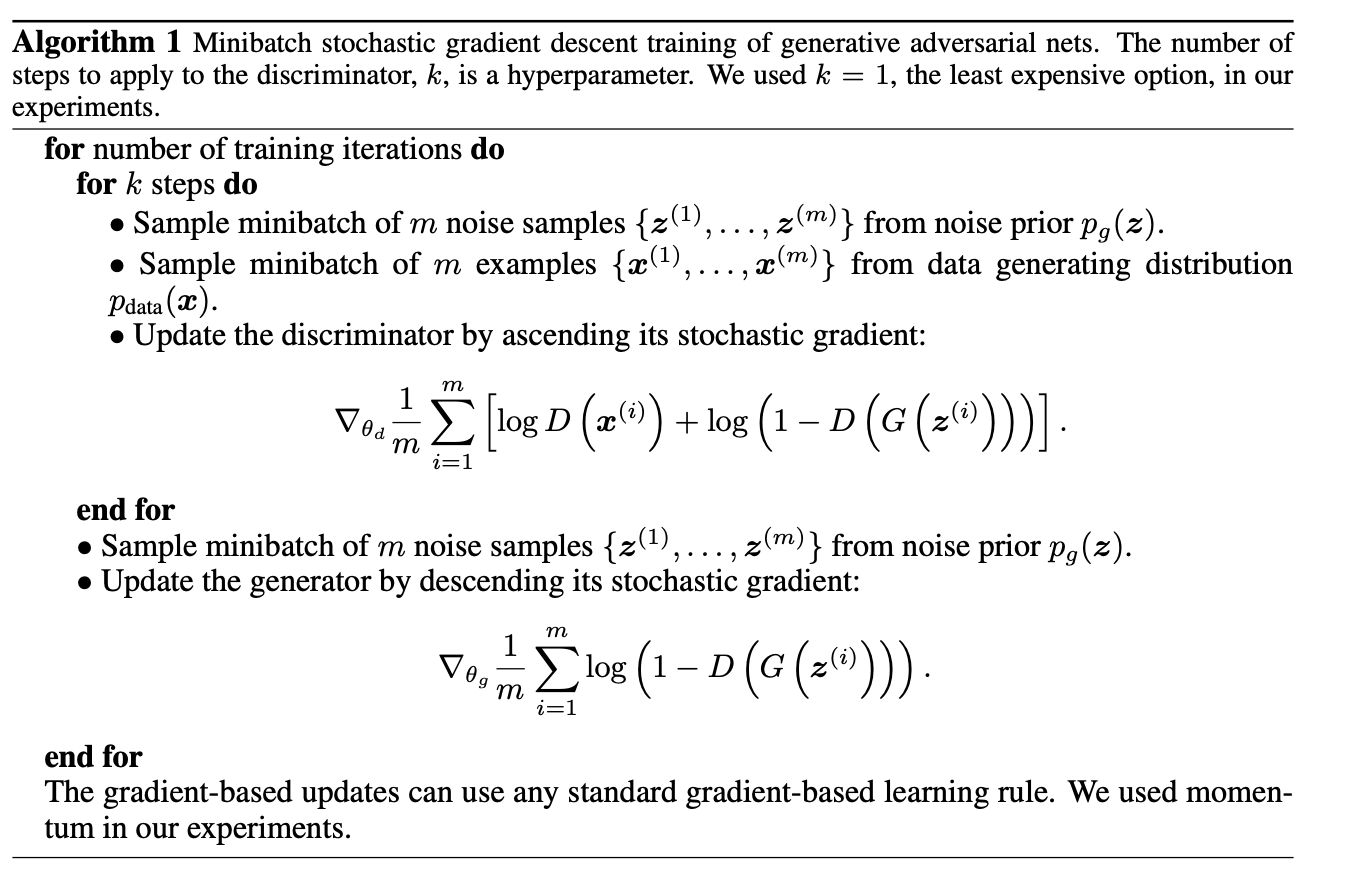

In [50]:
Image('./paper_data/additional_figures/gan_algorithm.png')

Unfortunately, this training process is seldom smooth. The objective of training a GAN is to find a Nash Equilibrium of a non-convex objective function with high dimensional parameters. This is very challanging and it is very difficult for the GAN to actually converge to such an equilibrium.(Salimans et al 2016) Instead one might observe situations where the Generative network is not able to provide realistic examples or where the network experiences "mode collapse," which is the phenomenon in which the generative network only learns to produce a very small number of samples. (Salimans et al 2016)

DCGANs, the model explored in this paper, solve some of those issue by using architectural as well training innovations. In addition to these innovations, there are also tricks that help stabilize the learning. Among those, some that where implemented in this paper are label smoothing (Salimans et al 2016)in which the training labels for the DCGAN (labels with respect to the crossentropy function) are smoothed, the use of dropout for regularization in the discriminator, and the separation of minibatches. A comprehensive list of these tricks can be found in the repository [Gan hacks](https://github.com/soumith/ganhacks#authors).

## 2. Summary of the Original Paper
### 2.1 Methodology of the Original Paper
As described above, training is quite difficult which might lead to suboptimal results. Moreover, architectural condisiderations might have a drastic impact on the quality of the results. The paper this project is meant to implement attempts to provide various improvements that help with the training process and the architecture of the Generator. In particular, it made 4 contributions. 

1. It proposed the DCGAN model, which is a new archictecture based on transposed convolutions as opposed to a feedforward architecture. 

2. It showed that the learned features of the discriminator can later be used as feature extractors in a supervised setting. 

3. It showed that the filters learned by the GAN have learned to draw specific objects. 

4. it shows that the generators have intersting arithmetic properties in the latent space. 

In my project I focused on objectives 1 ,2 and 3, and therefore I will only focus in summarizing these results. 

### 2.2.1 DCGAN Architecture
On the architectural side the paper proses modifying the normal GAN by doing three things. First, they add a convolutional net to the Generator. Second they eliminate fully connected layers. Third they use batch normalization to stabilize training. Finally, they use Relu for the generator and leaky Relu for the disciminator as activation functions. This architecture can then be vizualized with the following diagram. 

<!---[architecture](./paper_data/additional_figures/dcgan_architecture.png)--->

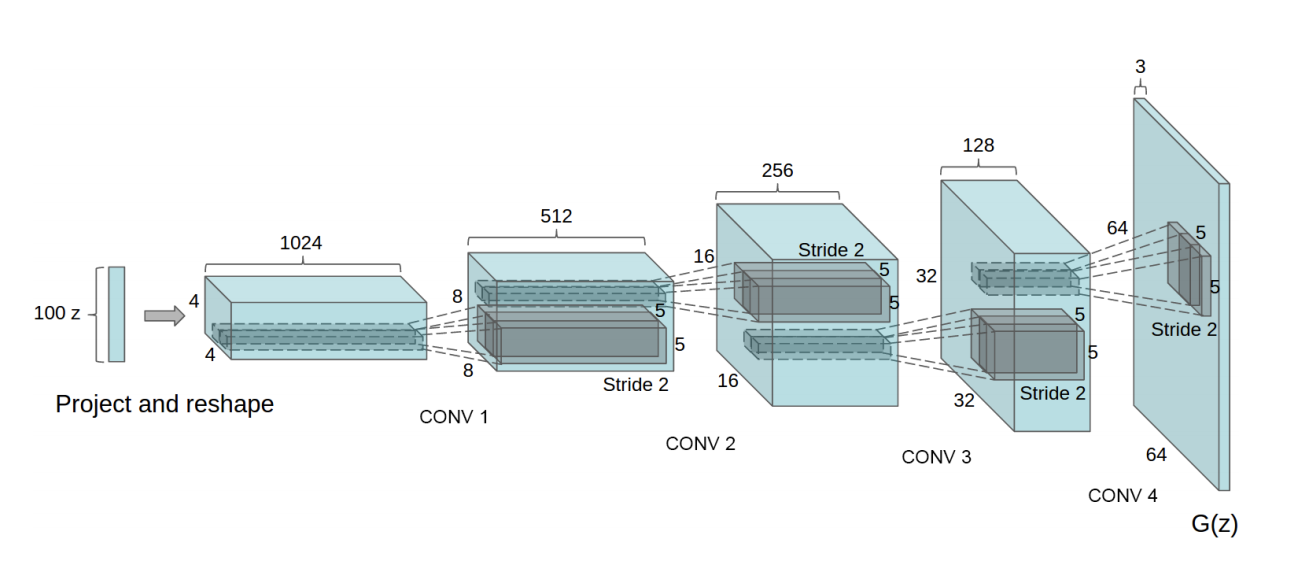

In [51]:
Image('./paper_data/additional_figures/dcgan_architecture.png')

For training this network they proposed using a batch size of 128, normalized images in the range $[-1,1]$, initializing all weight from a zero centedred normal distribution with standard deviation $0.02$, setting the paremeters of the leak to $0.2$ and using an Adam optimizer with a learning rate of $0.0002$ and a momentum term of $\beta_1 = 0.5$ as opposed to $0.9$ as the original paper suggests. (Kingma & Ba 2014). 

### 2.2.2 DCGAN as a Feature Extractor
To test that the model was indeed useful it was trained first on imagenet 1k with the parameters described above and then the discriminators convolutional features where maxpooled and flattened to obtain a vector representation. The trained discriminator was then used to extract features from CIFAR 10 data that was later used to train an SVM. This approach achieved $82.8%$ accuraccy, which is still less that traditional CNNs but is more than using a K-means based approach. Results of the sample images produced can be found below: 

<!---[image_net_results](./paper_data/additional_figures/image_net_paper_results.png)--->

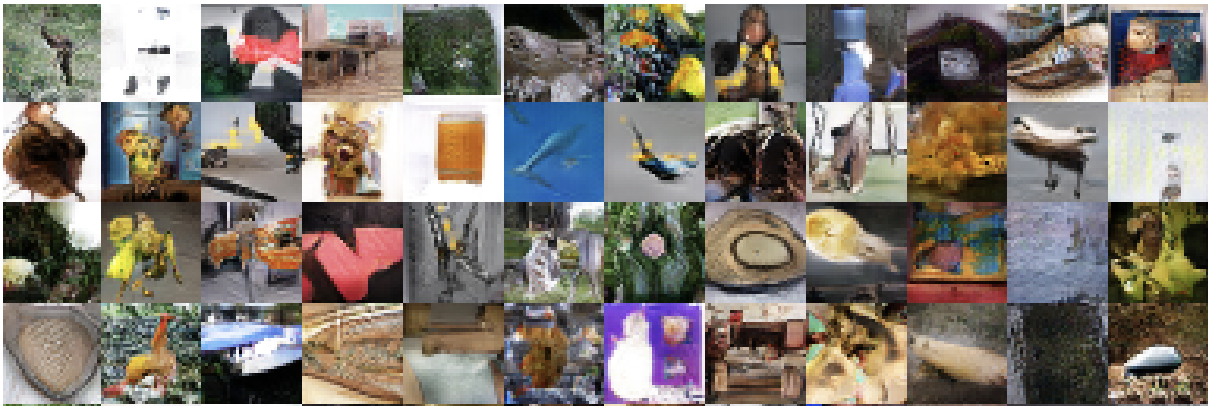

In [52]:
Image('./paper_data/additional_figures/image_net_paper_results.png')

### 2.2.3 Vector arithmetic and other experiments
In addition to testing the capabilities of the neural network to extract features, there were also multiple tests conducted to examine the way in which the latent space was being mapped into the data space. In particular, the paper conducted experiments using a dataset of 3 million faces from 10 thousand people and LSUN bedroom dataset which consists of 3 million photos of bedrooms. The two experiments relevant to this project were the vector algebra and space walking experiment. 

The vector algebra experiment consisted in using simple algebraic operations on the vectors in the latent space and then seeing if the results where semantically meaninful. Instead of using raw vectors, the paper used averages between semantically similar images because this led to more stable results. Below are images depicting both the vector arithmetic experiment and some of the generated faces

<!---![vector arithmetic](./paper_data/additional_figures/generated_faces.png)
![generated_faces_paper](./paper_data/additional_figures/vector_arithmetic.png)--->

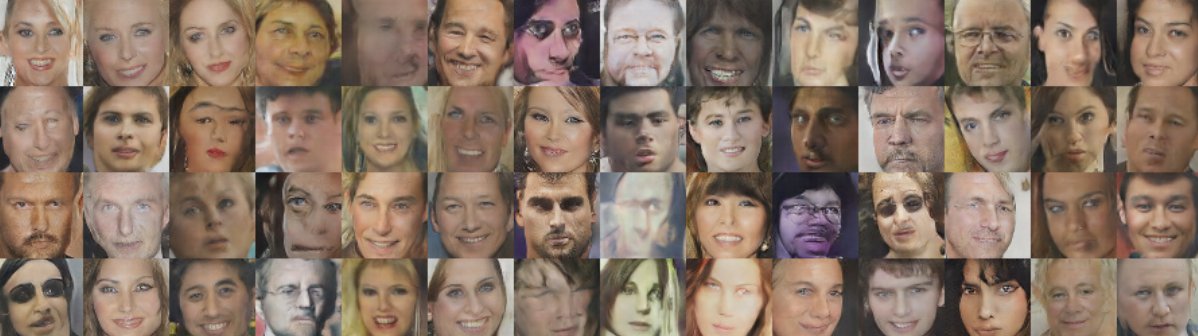

In [53]:
Image('./paper_data/additional_figures/generated_faces.png')

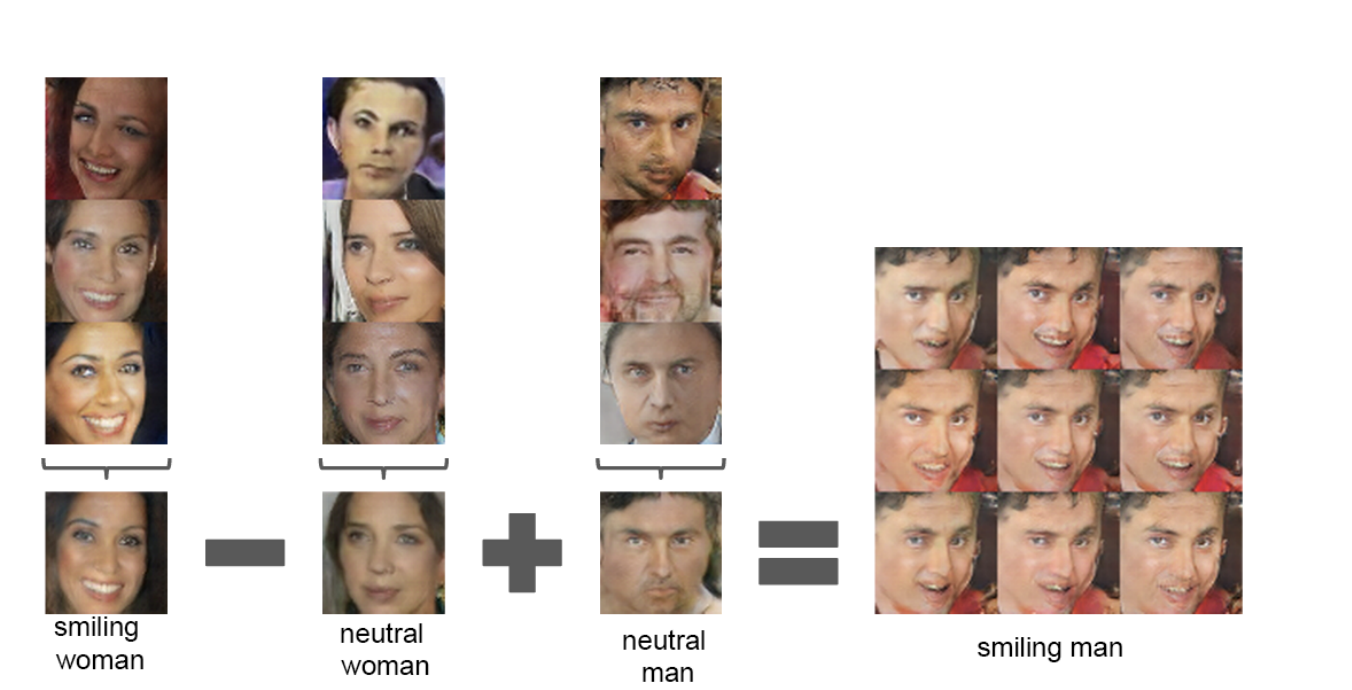

In [54]:
Image('./paper_data/additional_figures/vector_arithmetic.png')

The latent space walking experiment consisted in interpolating between random points in the latent space and observing the pictures these points where mapped to. The objective was to show that the manifold learned  was meaningful and there was no memorization. If memorization were present and the manifold was not meaningful then the interpolation woud show sharp changes rather than smooth transitions between both images. The paper performed these experiments with the LSUN dataset. 
<!--- ![space_walking](./paper_data/additional_figures/space_walking.png) --->

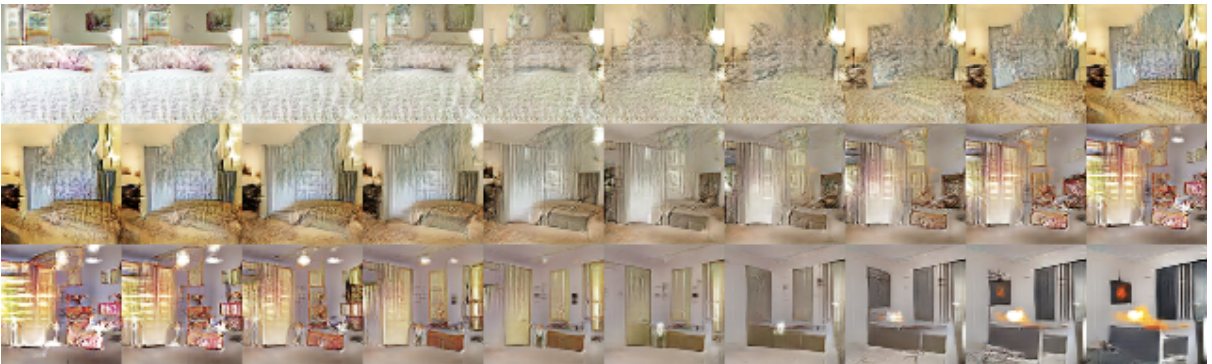

In [55]:
Image('./paper_data/additional_figures/space_walking.png')

## 3 Methodology of my Project
With the aim of exploring the results in the paper and understanding the limitations of the DCGAN model, this project replicated the results pertaining to the faces dataset and to the feature extraction capabilities of the model. In this section we formally describe the objectives, how these differ from the paper and the technical challanges these differences imply. 

### 3.1 Objectives and Technical Challanges. 

#### 3.1.1 Objectives
1. Train a DCGAN on a Faces-like dataset to obtain results of a similar quality of those presented in the paper. 

2. Perform algebra on vectors in the latent space of the faces data set to verify that the learned manifold contains semantically meaningful representations. 

3. Verify that learned manifold is not memorizing by walking in the latent space and interpolating between differnt faces. 

4. Train a DCGAN on small dataset to analyze the performace of the model in a low data regime. 

5. Train a support vector machine on learned features of the low-data model to asses the quality of the learned representations. 

#### 3.1.2 Challenges
The challges of these project can be divided in two different categories. 
Those challanges that are inherent to the training of GANs, and those challenges that are caused due to the particular objectives described above.

The challenges associated with GAN training are the following
1. Due to the nature of the objective function, it is not possible to monitor progress of the GAN by looking at the loss. Instead training needs to be closesly babysitted by reviewing produced images at training time. 

2. Depending on the dataset used, the discriminator might become profficient at detecting real versus fake examples faster than the generator acquires the capability of producing good imitations. 

3. Mode collapse can happen at any point of training. This requires a constant examination of results produced by the network. 

4. Due to the nature of the loss function used for training it is not as simple to directly asses whether an improvement is better or not. 

The challenges associated with the pariticular objectives of the project are described below. 

1. In a low data regime the model is more likely to be unstable because the diversity of the examples provided is so small that the discriminator can easily overfit. 

2. Low data regimes might exacerbate the mode collapse problem as the generator doesn't have a lot of examples to learn from. 

Later on, when explaining in detail the architectures used we will describe steps that were taken to mitigate these issues. 

### 3.2 Problem formulation and Design Description

#### 3.2.1 Problem Formulation
To achieve these objectives we will follow the same problem formulation provided in the introduciton to the general GAN framework. The only changes from these descriptions are the architecture of the deep learning framework that we will use, and the latter feature extraction step.

Formally, using the notation establsihed in the introduction we will attempt to find a solution to the minimax game 
$$ \min_G \max_D V(D,G) = E_{x \sim p_{\text{data}}}[\log(D(x))] + E_{z \sim p_z(z)}[\log(1 -D(G(z))]$$
where we will assume that $p(z) \sim \mathcal{N}\left(\vec{0},I_{100}\right)$ where  $I_n$ denotes the idenity matrix of dimension $n$ , $p_{\text{data}}$ is replaced by the pariticular data distribution at hand, and $G$ and $D$ are created following the architectural considerations stablished in the DCGAN paper. This is the formulation for the traditional GAN framework as expressed before. 

The problem formulation for the feature extraction can then be described as follows. Recall that $\theta_d$ and $\theta_g$ parametrize the discriminator and generator repespectively (see introduction). Assume that $\mathcal{X}$ is the data space, images from these dataspace belong to $l$ classes and $F$ represents some feature space. Then our unsupervised learning forumation can be described as finding a transformation $T: \mathcal{X} \to F$ parametrized by $\theta_d$ such that the accuracy of some learner $\mathcal{A}$ increases when trained on data transormed by $T$ as opposed to trained on $\mathcal{X}$. In our case, the learner $A$ that we will use will be a support vector machine. The particular transformation $T$ that we will be described later when considering network architectures. 

Finally, to complete the problem formulation, we need to specify how we will train our algorithms. For solving the minimax problem we will use the training algorithm described in the introducion with an Adam optimizer, and for training the support vector machine we will use vanilla SGD. 

#### 3.2.2 Datsets
To train the models we used two datasets:
1. **Celeba**: The celeba dataset (liu 2015) was used as a replacement for the faces dataset found in the original paper. It consists of 202,599 face images. Each image was rescaled to be $64 \times 64$ size and no augmentations were performed nor additional croppings. As opposed to the original paper, the background was visible and for some photos it is possible to see a small part of the body. Below is a sample of the images used 

In [3]:
img_size = (64,64)
batch_size = 128
data_dir = './data/img_align_celeba'
ds_t = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    shuffle=True,
    seed=123,
    label_mode=None,
    image_size = img_size,
    batch_size=128
)


Found 202599 files belonging to 1 classes.


In [4]:
batch = [image for image in ds_t.take(1)][0]
utils.make_grid(batch, 9*9, './paper_data/celeba/celeb_sample_images.png')

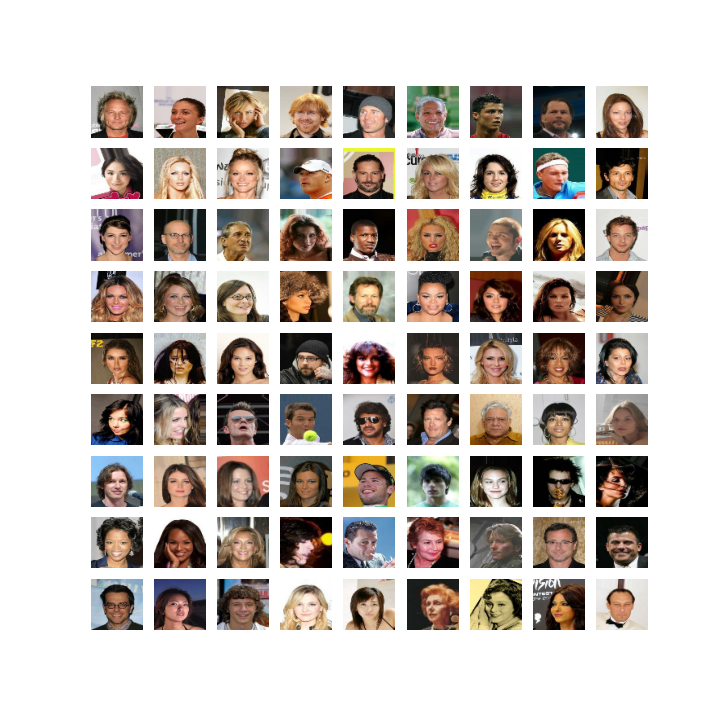

In [56]:
Image('./paper_data/celeba/celeb_sample_images.png')

<!---![sample_celeba_images](./paper_data/celeba/celeb_sample_images.png)--->

2. **CIFAR 10**: For the experiments related to the unsupervised feature extraction I decided to use CIFAR 10(Krizhevsky 2009) as opposed to Imagenet as was done in the paper. This dataset is significanlty smaller than the one used in the paper but it allows us to check if using a large dataset is neccesary to obtain good results. Sample images from this dataset are provided below. No cropping or data augmentation was performed to this dataset. 


In [57]:
train, val = tf.keras.datasets.cifar10.load_data()
Xt = np.concatenate((train[0],val[0]))
batch_gen = utils.make_batch_generator(Xt)

In [58]:
utils.make_grid(tf.Variable(next(batch_gen)), 9*9, './paper_data/cifar10/sample_images.png')

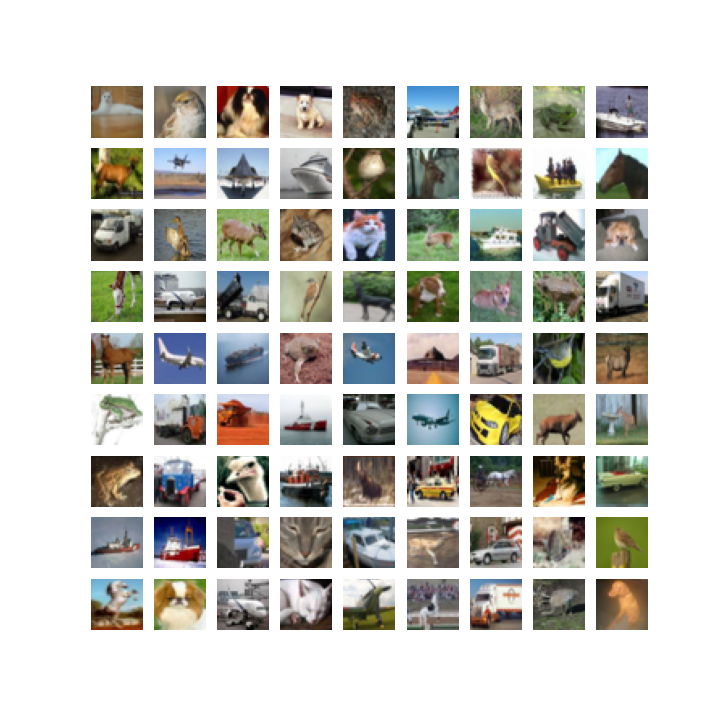

In [59]:
Image('./paper_data/cifar10/sample_images.png')

<!--- ![cifar_10_data](./paper_data/cifar10/sample_images.png) --->

#### 3.2.3 Design of Project

Having already explained exactly how we will proceed I provide below a flowchart of the process of how the experiments will be conducted. An important point to be made is that although the word hyper-parameter suggests that we will only be modifying things such as learning rate and similar parameters, due to the complexity of training a GAN, we will also be modifying more complex parameters such as the point where the gradient is calculated, degree of smoothness for labels, quantity of dropout and number of droput layers. 
<!--- ![flowchar](./paper_data/additional_figures/flowchart.png) --->

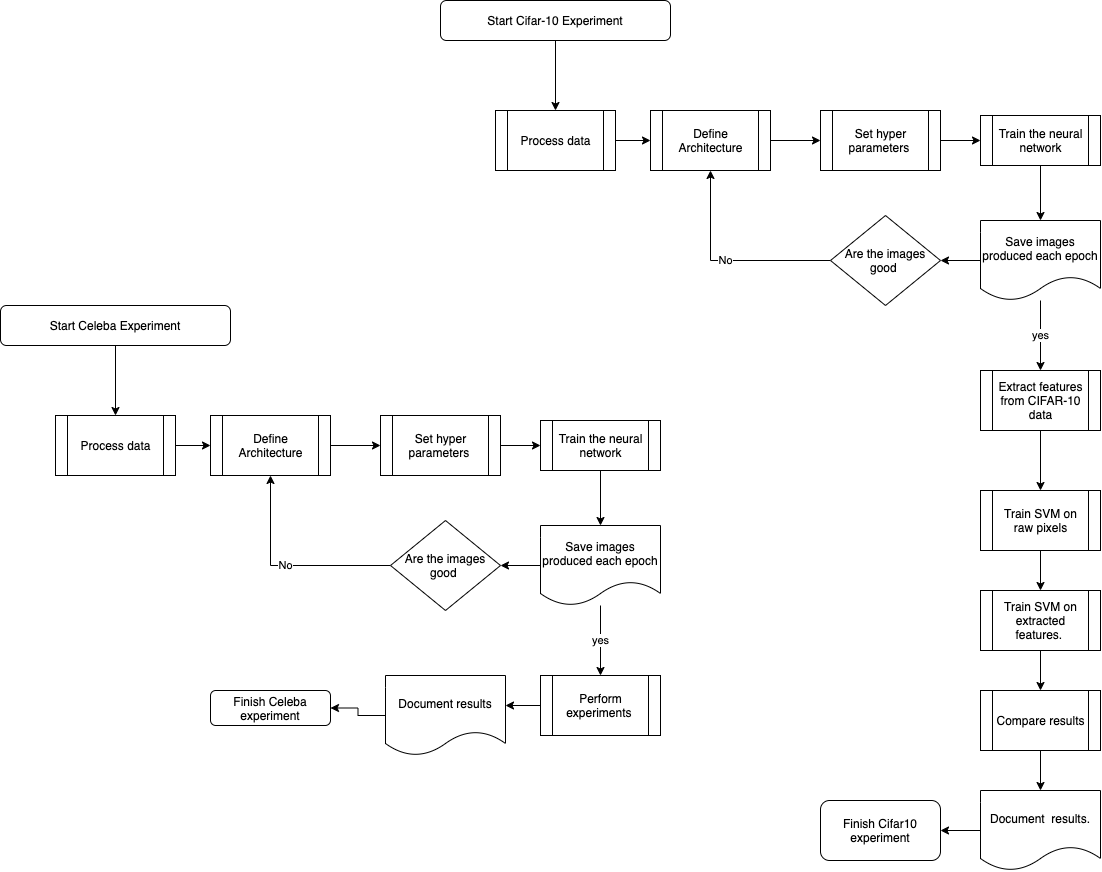

In [61]:
Image('./paper_data/additional_figures/flowchart.png')

## 4. Implementation
The implemntation of my neural network followed very closely that of the paper. A careful attempt was made to replicate their architecture as much as possible when guidance was provided. However, specially for the second experiment, it was neccesary to deviate from the architecture that was proposed because 1. There was not enough guidance in the paper 2. The network was unstable and the discriminator got to good to quickly which led to poor results. Below I provide a careful explanation of the architectural desicions made and diagrams of the network used. Additionally, I will provide a careful description of the effots that were made to optimize the neural network alongside an explanataion of why this desicions were taken. 
### 4.1 Celeba network and training 
#### 4.1.1 Network
The generator network for the celeba experiments followed that of the paper. In the convolutional layers I added strides only so that the dimensions matched those provided in the paper. For the discriminator network I used a LeNet inspired architecture but getting of most dense layers and without using pooling operations. Block diagrams of the architectures are provided below. Some important notes are the following.

1. The weight initialization scheme followed closely that of the paper. Every weight in both networks was initialized to a standard normal distribution with mean 0 and standard deviation 0.02. 

2. Instead of using ReLU activations for the generator I decided to use LeakyReLU as this proved to have a beneficial effect in terms of convergence of the algorithm. 

3. I used batch normalization after every convolution as described by the paper. 

4. In the last layer I use Tanh so that the activations match the normalized range of images. 



In [62]:
# Parameters to train with 
epochs = 24
start_epoch = 0
print_freq = 25
checkpoint_dir = 'DCGAN/celeba_checkpoints'
progression_images_dir = 'paper_data/celeba/progression_images'
discriminator = models.build_discriminator()
generator = models.build_generator()
save_img_freq = 500
checkpoint = tf.train.Checkpoint(
    generator = generator,
    discriminator = discriminator,
)


In [63]:
checkpoint = tf.train.Checkpoint(
    generator = generator,
    discriminator = discriminator,
)
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

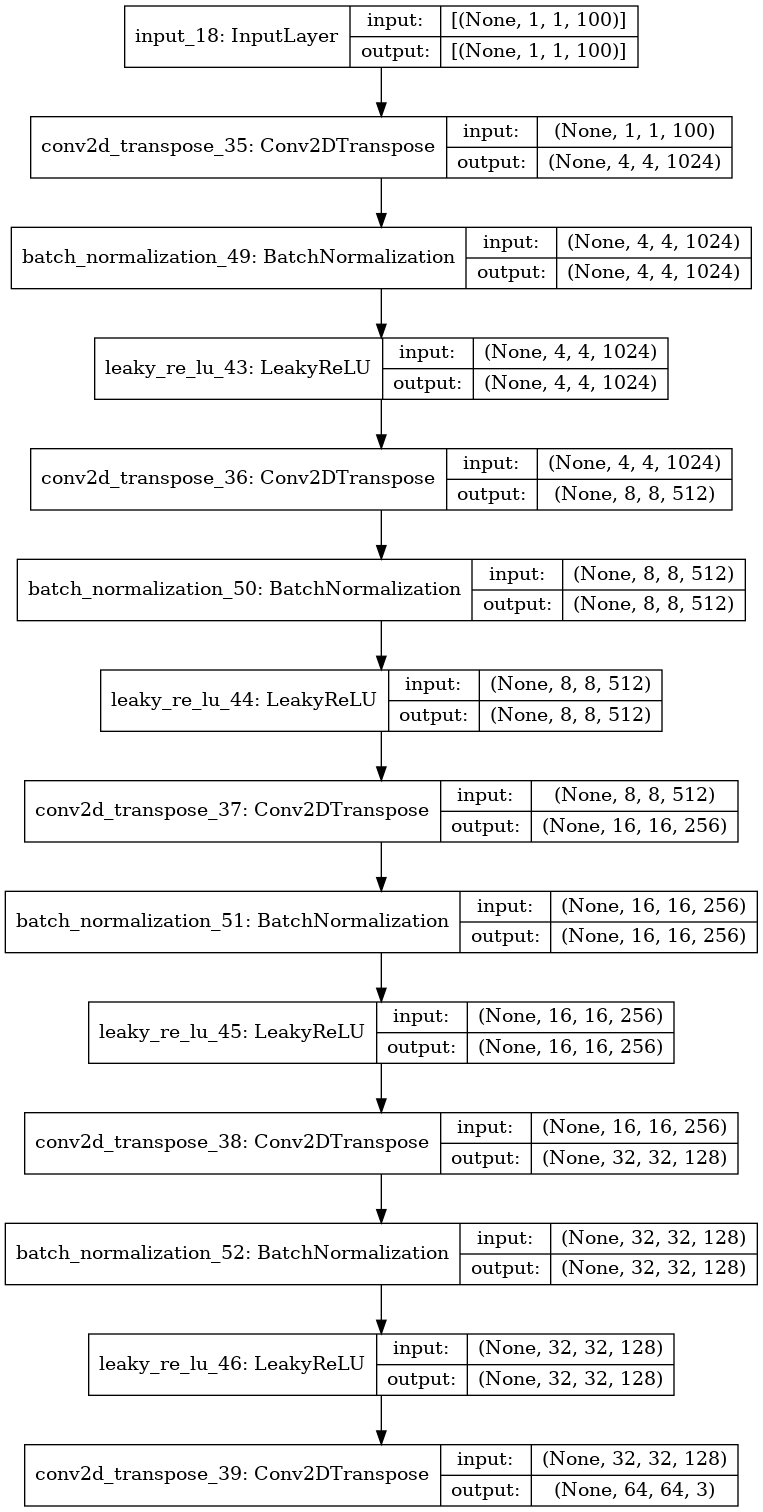

In [66]:
plot_model(generator, show_shapes='True', to_file='./paper_data/celeba/generator.png')


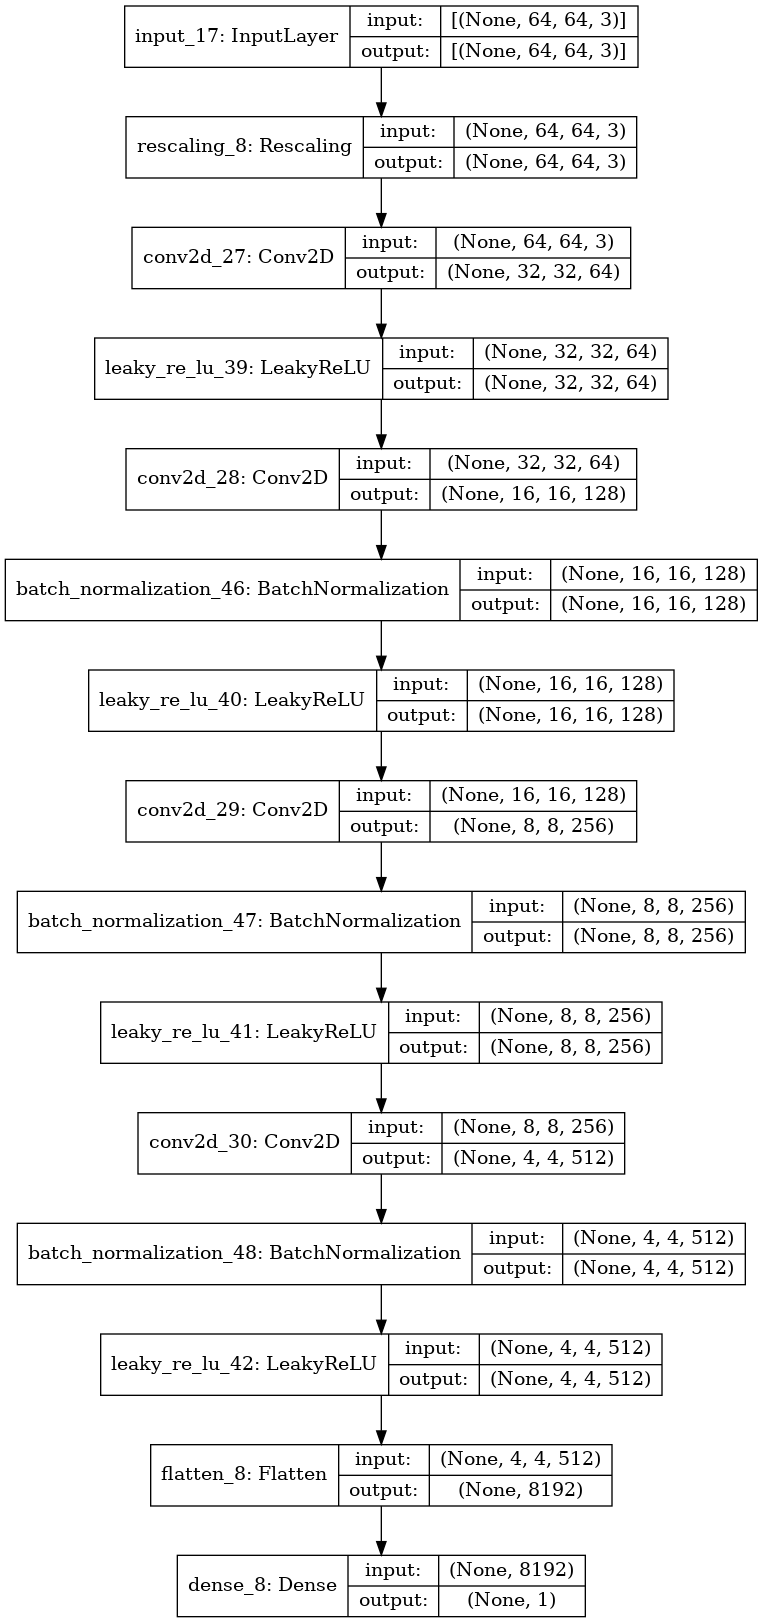

In [67]:
plot_model(discriminator, show_shapes=True,to_file='./paper_data/celeba/discriminator.png')


<!--- **Generator**: 


<img src="./paper_data/celeba/generator.png" alt="celeb_generator"
	title="celeba generator" width="300" height="300" />

**Discriminator**:

<img src="./paper_data/celeba/discriminator.png" alt="celeb_discriminator"
	title="discriminator" width="300" height="300" />

--->


#### 4.1.2 Training
For the training algorithm we follow the pseudocode provided in the introduction. This is the same algorithm generally used for GANs. Some of the modifications we make are the following: 

1. I used $\log(D(G(z))$ instead of $\log(1 - D(G(z))$ as suggested by goodfellow. This means that in the last part of the algorithm we replace the descending step by an ascending step with the new loss. 

2. I used the hyper paramters provided by paper and an Adam optimizer as suggested by the paper. This included setting the learning rate to 0.0002 instead of 0.001 and I changed the momentum term to $\beta_1 = 0.5$ instead of $0.9$ as is suggested by (Kigma & BA 2014). 

3. I used a batch size of 128 as suggested by the paper. 

4. I trained for 25 epochs which took approximately $10$ hours. I monitored the progress of the network closely by constantly checking the images provided by the network. I choose to train for this number of epochs because it allowed me to train the network architecture and try different optimization schemes. However, none seem to yield results better than the one described above. 

The training algorithm and implementation can be found in this [file](https://github.com/ecbme4040/e4040-2021spring-project-nbvv-nb2838/blob/main/DCGAN/celebamodels.py)

In [27]:
# Train the model
if presentation == False: 
    histories = models.train(
        generator, 
        discriminator, 
        ds_t, 
        epochs = epochs, 
        start_epoch = start_epoch,
        print_freq=print_freq, 
        checkpoint_dir=checkpoint_dirc,
        progression_images_dir=progression_images_dir,
        save_img_freq=save_img_freq
    )



### 4.2 Cifar network and training 
In this section we provide a description of the neural network architecture and the training algorithm as used for the CIFAR 10 dataset. In addition, I report my efforts to optimize the neural network architecture. 
#### 4.2.1 Network 
The neural network architecture is very similar to the one detailed above. The differences can be categorized in three ways: efforts to regularize the discriminator, differences due to image sizes and differences to extract features. I will explain these categories below. In addition to these modifications I decided to use ReLU instead of Leaky ReLU because in tests it provided better images. 

- **Image Sizes:** Due to varying image sizes I removed the last layer of the generator and adjusted activations accordingly so that images of size 32 x 32 would be produced. 

- **Feature Extraction**: To extract features I added a global max pooling layer on top of every convolutional layer in the discriminator. This was done in parallel to the architecture described before. The original paper did not provide a clear guidance on how to extract features so I chose this approach as a combination of what was suggested in the paper and what was explored in class. 

- **Regularization**: The main issue that I faced during training was that the generator quickly became too good and training quickly became unstable. This severely impacted the quality of training. To combat this issue I reduced the depth of the Discriminator to decrease its capacity and added dropout layers. I found that adding one dropout layer at the end of the network and one dropout layer inside of the network reduced the capacity enough to allow the generator to learn. 
    
    In addition to my final solution. I also attempted to add one dropout layer, to add dropout to the input variables, and to provide no regularization. Below, there are pictures of the results of these attempts after 10 epochs of training which justify the changes I made. The pictures correspond to no dropout, input dropout, last layer dropout respectively. Using only one layer of dropout worked well but after 30 epochs the results deteriorated very quickly. The training time for the CIFAR dataset was of about 5 hours for a 100 epochs which allowed for more iterations over the training process.  

<!---./paper_data/additional_figures/no_dropout.png  ./paper_data/additional_figures/input_dropout.png ./paper_data/additional_figures/one_dropout.png --->    
The diagrams below detail the architecture of the network used. 


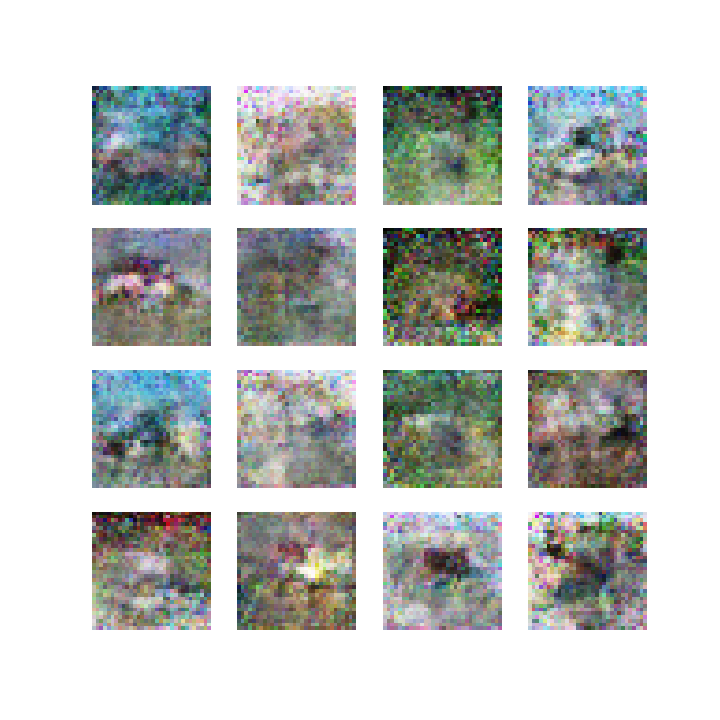

In [69]:
Image('./paper_data/additional_figures/no_dropout.png')

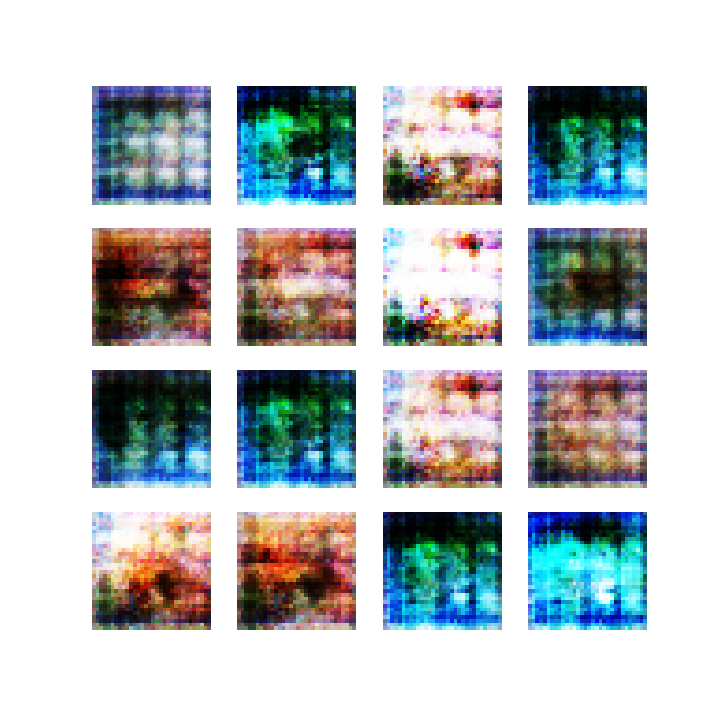

In [70]:
Image('./paper_data/additional_figures/input_dropout.png')


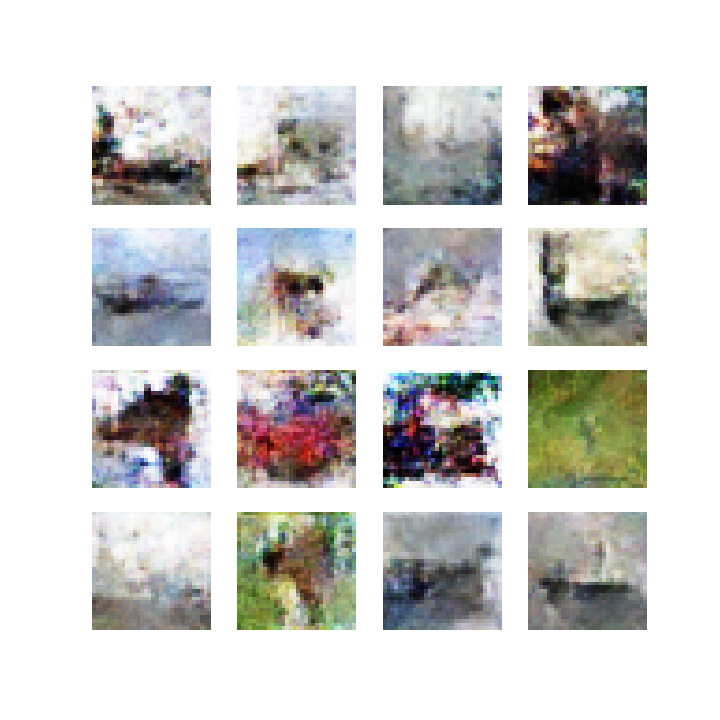

In [71]:
Image('./paper_data/additional_figures/one_dropout.png')

In [72]:
cifgenerator = cifmodels.build_generator()
cifdiscriminator = cifmodels.build_discriminator()

In [73]:
# Define parameters for training
epochs = 50
start_epoch = 0
print_freq = 50
checkpoint_dir = 'DCGAN/cifar10_checkpoints'
progression_images_dir = 'paper_data/cifar10/progression_images'
cifgenerator = cifmodels.build_generator()
cifdiscriminator = cifmodels.build_discriminator()
save_img_freq = 400
checkpoint = tf.train.Checkpoint(
    cifgenerator = cifgenerator,
    cifdiscriminator = cifdiscriminator,
)


In [74]:
# Load a previous model if one exists
checkpoint = tf.train.Checkpoint(
    cifgenerator = cifgenerator,
    cifdiscriminator = cifdiscriminator,
)
latest = tf.train.latest_checkpoint('DCGAN/cifar10_checkpoints/')
checkpoint.restore(latest)

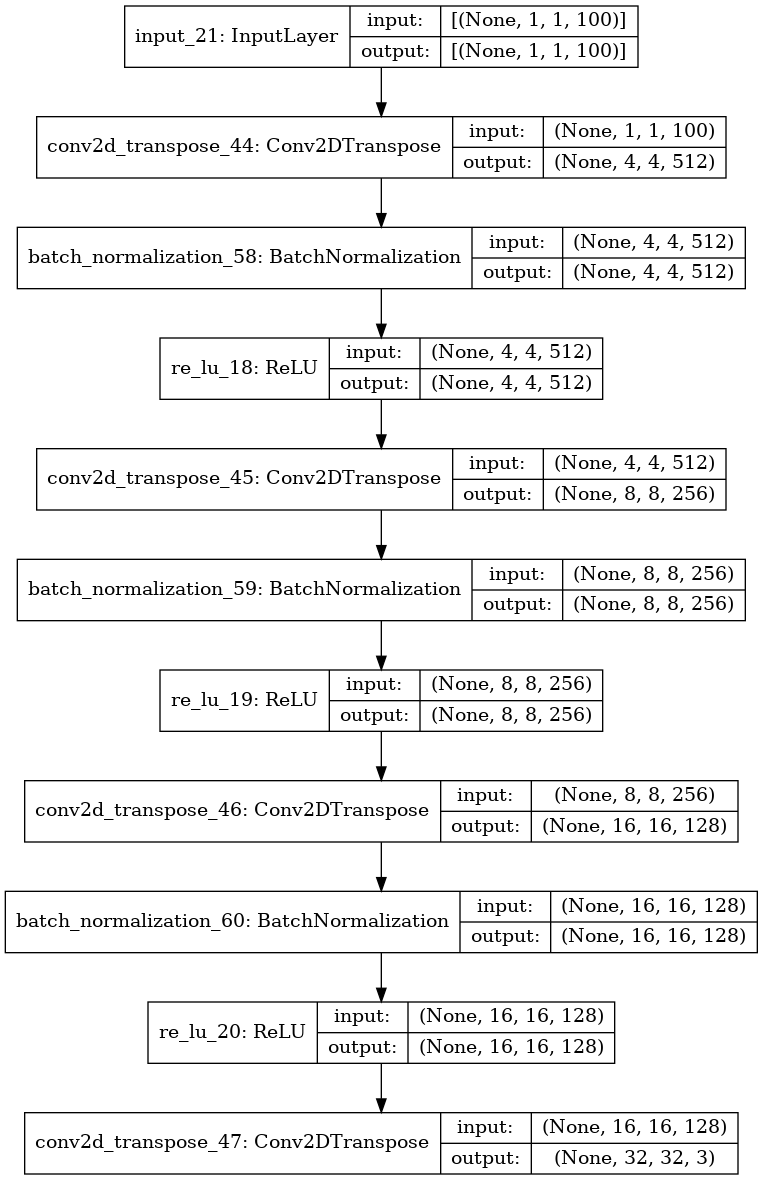

In [75]:
plot_model(cifgenerator, to_file='./paper_data/cifar10/generator.png',show_shapes=True)

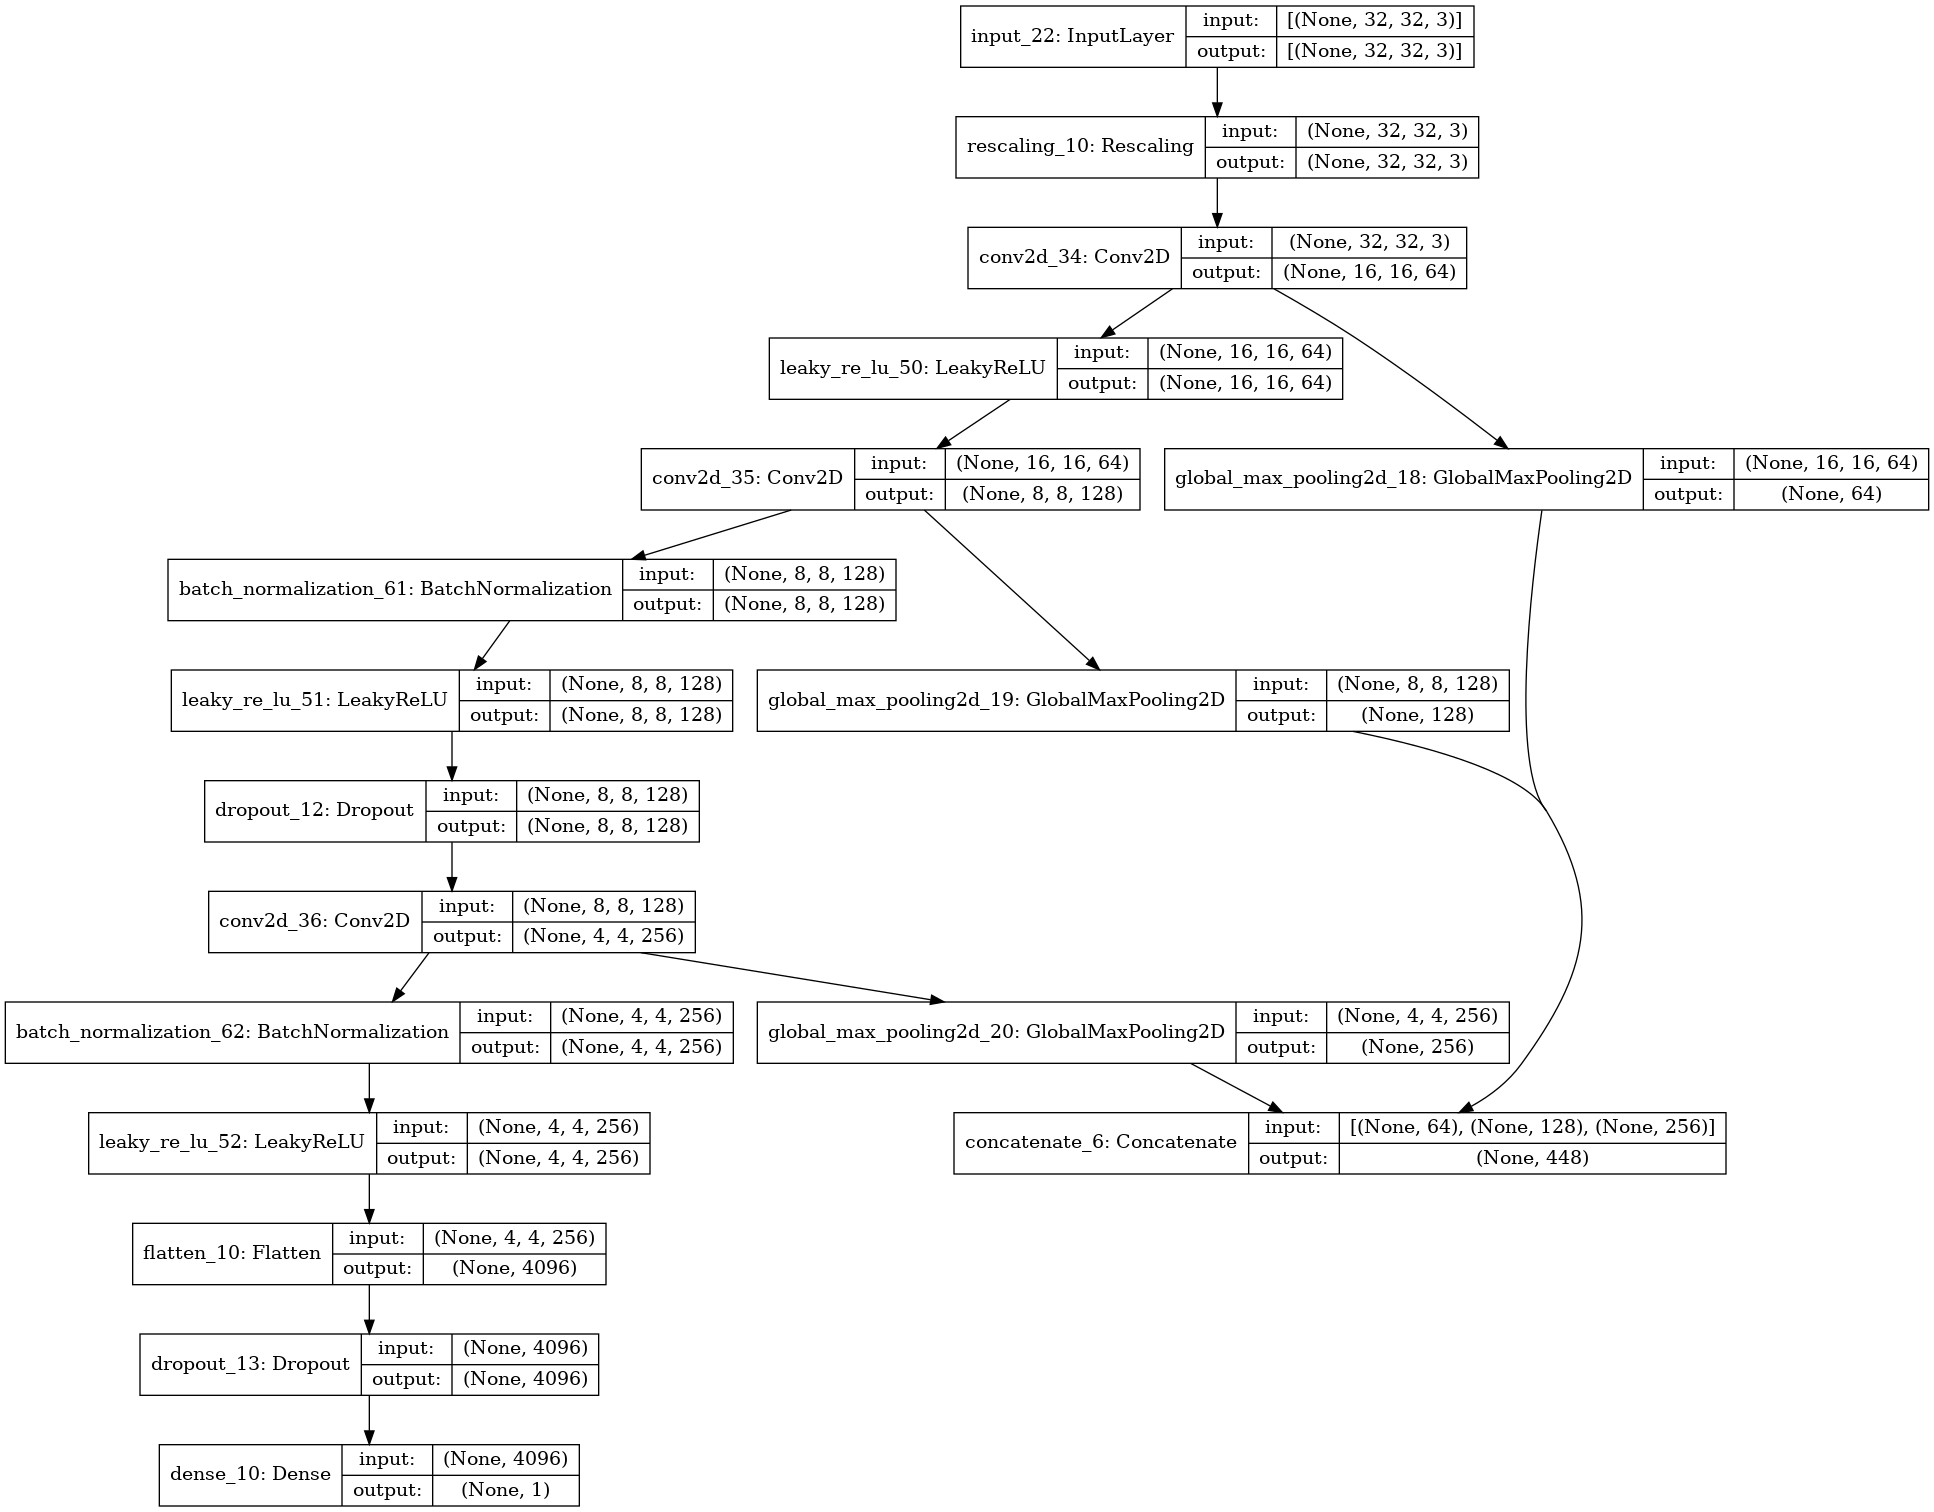

In [76]:
plot_model(cifdiscriminator,show_shapes=True, to_file='./paper_data/cifar10/discriminator.png')

<!--

**Generator**: 


<img src="./paper_data/cifar10/generator.png" alt="celeb_generator"
	title="celeba generator" width="300" height="300" />

**Discriminator**:

<img src="./paper_data/cifar10/discriminator.png" alt="celeb_discriminator"
	title="discriminator" width="600" height="300" /> --->
    
#### 4.2.2 Training
As explained above, the main difficulty for training the network was that the generator quickly was able to differentiate very well between fake and real pictures. Althought the modification of the architecture detailed above heleped with this difficulty some additional measures were taken which slightly modified the training procedure used for the Celeba dataset. I will explain what these modifications were. Besides these changes the training algorithm was the same:

1. Label Smoothing: I used label smoothing for the samples provided to the discriminator. This means that rather than providing a label of $1$ or $0$ for real and fake examples I used a random value between $0.7-1.2$ and $0-0.3$. Different values were tried and there didn't seem to be any significant difference between changing this range much. However, using Label Smoothing improved the quality of the images significantly. 

2. I calculated the gradients for the left and right term of the loss function independently as this was suggested as a way of gaining stability in the Gan hacks document referenced before. This helped only slightly with the training. I attempted to also update only at the end of training but this decreased the quality of the updates. 

3. I attempted to use different optimizers for the generator and the discriminator. In particular, I attempted to use SGD with momentum for the discriminator and to use Adam for the generator. The rationale was that doing so would slow the improvement of the discriminator so that the generator could catch up. Unfortunately this wasn't the case so I didn't add this modification. 

Besdies these changes everything was done in the same way as in the Celeba dataset. Because of the reduced size of the dataset I was able to train for up to 100 epochs instead of 20. However the results didn't improve for more than 50 epochs so I present those below. After 50 epochs there was a drastic mode collapse. Additionally, it is important to note that the outputs for the feature extractino were not used in any way during the training process. They were simply ignored and therefore didn't affect the calculation of the gradients. The code for the implementation can be found in [this file](https://github.com/ecbme4040/e4040-2021spring-project-nbvv-nb2838/blob/main/DCGAN/celebamodels.py).


In [155]:
if presentation == False: 
    histories = cifmodels.train(
        cifgenerator, 
        cifdiscriminator, 
        batch_gen, 
        epochs = epochs, 
        start_epoch = start_epoch,
        print_freq=print_freq, 
        checkpoint_dir=checkpoint_dir,
        progression_images_dir=progression_images_dir,
        save_img_freq=save_img_freq
    )

### 4.3 Software design
Given that the project didn't require the interaction of many elements, the software design of my project was simple. It consists only of the models, plus custom training algorithms that have been described above. With the aim of being conscise I don't repeat these descriptions here. Additionally, links to the relevant code in Github can be found above. Everything was done using Tensorflow version 2.4 (the change in version was simply due a clash in my machine), keras and scikit-learn for the SVMs. Given that there were various modifications to the training loop that needed to be implemented, I used the direct autograd capabilities of Tensorflow rather than the premade keras fit methods. 

## 5 Results
In this section I will show the results of the experiments conducted and will compare them to those obtained by the authors. 
### 5.1 Celeba Experiments
#### 5.1.1 Image generation 
<!--- ./paper_data/celeba/celeb_generated_images.png --->

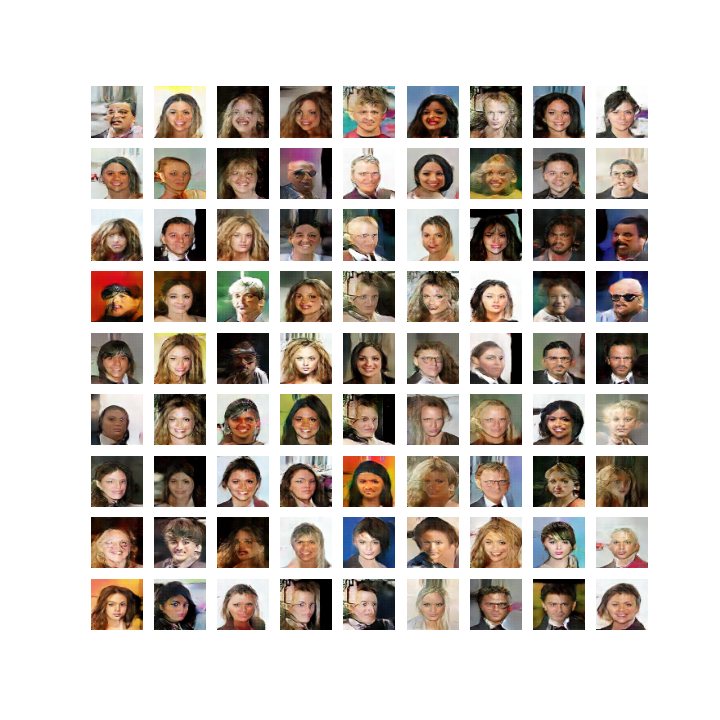

In [32]:
# I use a seed so that the code can be reproduced 
np.random.seed(2)
num_images = 9*9
latent = np.random.normal(size=(num_images,1,1,100))
batch = (generator(latent) * 127.5) + 127.5
utils.make_grid(batch, num_images, './paper_data/celeba/celeb_generated_images.png')
Image(filename='./paper_data/celeba/celeb_generated_images.png')

As can be observed from the pictures above, the results are comparable to those obtained by the authors. An inportant difference is that because the images that we provided had, hair, background and body the generator learned to produce this as well. Similarly, because the genrator has to focus on more things, sometimes it learns to produce images of comparable but slightly lower quality.

#### 5.1.2 Algebra on images
The images below, show that the generator for the Celeba dataset is able to learn semantically meaningful representations. These are only some of the experiments I conducted. Below, we see for example that (brown hair woman)- (brown hair man) = ( blonde woman). I attempted to reproduce the results in the paper exactly but unfortunately because the representations now contain more information that just the face it was harder to get a one to one comparison. For example, now the representations need to encode things such as, length of hair, background, type of shirt (etc). This entanglement of the representations makes it difficult to perform the same type of algebra calculations. The interpretations are still possible as the experiment shows. 

An important note is that to improve stability we use averages over various latent space images. 

<!--- ./paper_data/celeba/woman_blonde.png --->
<!--- ./paper_data/celeba/brown_hair_man.png--->
<!---./paper_data/celeba/brown_hair_woman.png --->

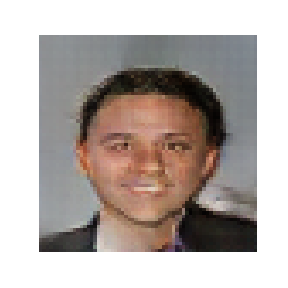

In [33]:
brown_hair_man = (latent[21] + latent[16] + latent[19])/3
brown_hair_man = np.expand_dims(brown_hair_man, 0)
brown_hair_manp = generator(brown_hair_man) * 127.5 + 127.5
utils.make_grid(brown_hair_manp, 1, figsize=(4,4), path='./paper_data/celeba/brown_hair_man.png')
Image(filename='./paper_data/celeba/brown_hair_man.png')

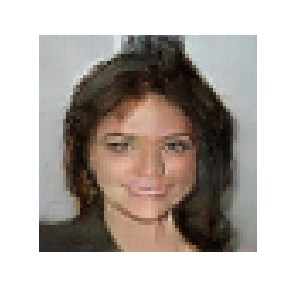

In [34]:
brown_hair_woman = (latent[9*7 + 4] + latent[7] + latent[8])/3
brown_hair_woman = np.expand_dims(brown_hair_woman, 0)
brown_hair_womanp = generator(brown_hair_woman) * 127.5 + 127.5
utils.make_grid(brown_hair_womanp, 1, figsize=(4,4),path='./paper_data/celeba/brown_hair_woman.png')
Image(filename='./paper_data/celeba/brown_hair_woman.png')

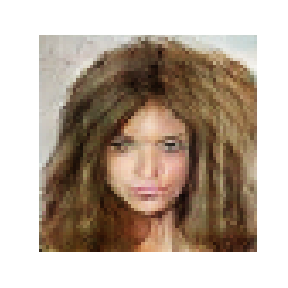

In [35]:
woman_blonde =    brown_hair_woman - brown_hair_man
woman_blondep = generator(woman_blonde) * 127.5 + 127.5
utils.make_grid(woman_blondep, 1, figsize=(4,4), path='./paper_data/celeba/woman_blonde.png')
Image(filename='./paper_data/celeba/woman_blonde.png')

#### 5.1.3 Smooth transitions in Latent Space
The pictures below show the transition from a between two points in the latent space. We see that the transition between these two points is coherent and smooth. This means that every vector in the transition represents a valid person. Moreover, we can see that there are no abrupt changes. Instead the color and background of the woman's hair changes seamelesly from one to the next. This further supports the hypothesis posited above above the vectors encoding much more than just facial features. 

In [42]:
spoint = latent[1]
endpoint = latent[7]
diffvect = endpoint - spoint
midpoints = [spoint + diffvect * t for t in np.linspace(0,1,10)]
midpoints = np.array(midpoints)
transition_images = generator(midpoints) * 127.5 + 127.5

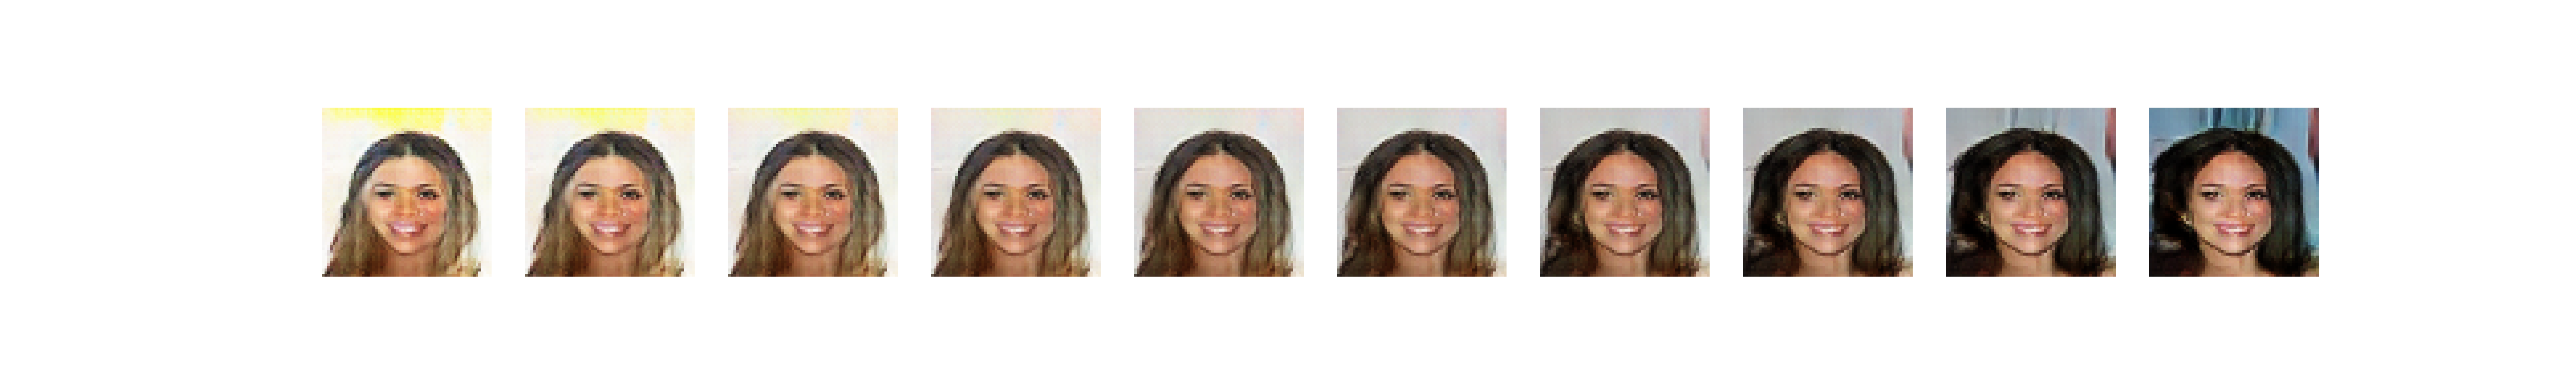

In [48]:
fig = plt.figure(figsize=(20,3))
num_figs = len(transition_images)
for i in range(num_figs): 
    ax = fig.add_subplot(1, num_figs, i+1)
    ax.imshow(transition_images[i].numpy().astype('uint8'))
    ax.axis('off')
    
plt.savefig('./paper_data/celeba/smooth_transition.png',dpi=300)
plt.close()
Image('./paper_data/celeba/smooth_transition.png')

### 5.2 Cifar 10 results
#### 5.2.1 Images generated 
Below I show the results of the images from the Cifar 10 dataset. As we can see there are some pictures that are distuinguishable. Among them it is possible to distinguish dogs, cars, boats, planes and horses. However, the quality is not as good as those produced by the paper. These results were after several rounds of improvements and modifications to the neural network architecture. These changes are the ones described above. It is very likely that the low quality is simply due to the small amount of images compared to those in imagenet. 

Additionally, it is evident that some of the images are very similar to each other which indicates some level of mode collapse. 

<!--- ./paper_data/cifar10/generated_images.png --->

In [49]:
np.random.seed(29)
latent = np.random.normal(size=(9*9,1,1,100))
batch = (cifgenerator(latent) * 127.5) + 127.5
utils.make_grid(batch, 9*9, './paper_data/cifar10/generated_images.png')


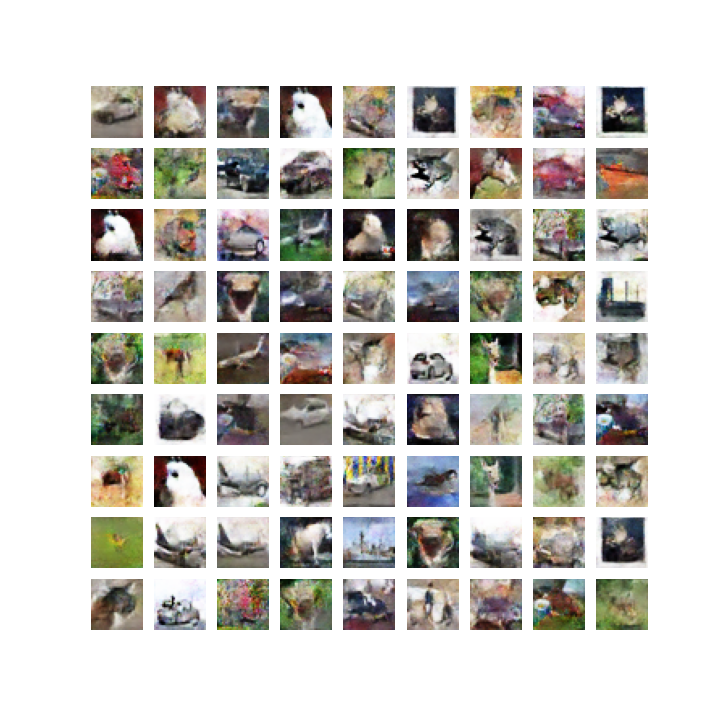

In [159]:
from IPython.display import Image
Image(filename='./paper_data/cifar10/generated_images.png')

#### 5.2.2 Extraction of features
After extracting the features we trained an SVM classifier on the CIFAR-10 datset. The classifier was trained using SGD as other training methods were too slow. The results however were signficantly worse than the paper. Although I managed to construct a classifier that improved performance over raw pixel data by approximately 30 percent, it still was not close to the accuracy reported in the paper. The values I obtained were an accuracy of $0.49222$ for the classifier trained on learned features and an accuracy of $0.386$ for the classifier trained on the raw pixels. Below there are plots of the confusion matrices for both classifiers. An effort was made to optimize these results using cross validation but no values yielded a significant improvement.

In [187]:
xtrain, ytrain = train[0], train[1]
xval, yval = train[0], train[1]
_, xtfeat = cifdiscriminator.predict(xtrain)
_, xvfeat = cifdiscriminator.predict(xval)

In [199]:
from sklearn import linear_model as lm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=10000,alpha=0.001, tol=1e-4,verbose=0,loss='hinge',n_jobs=-1))
clf.fit(xtfeat, ytrain.T[0])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, max_iter=10000, n_jobs=-1,
                               tol=0.0001))])

In [190]:
clf.score(xvfeat, yval.T[0])

0.49222

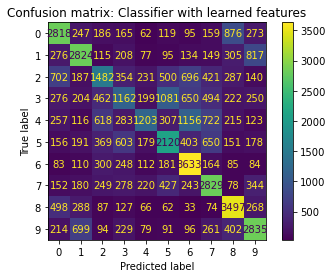

In [200]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, xvfeat,yval.T[0])
plt.title('Confusion matrix: Classifier with learned features')
plt.savefig('./paper_data/cifar10/confusion_matrix_learned_features.png',dpi=300)

In [198]:
clf = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=1000,alpha=0.001, tol=1e-4,verbose=0,loss='hinge',n_jobs=-1))
xflat = np.reshape(xtrain, (-1,32*32*3))
clf.fit(xflat, ytrain.T[0])

In [194]:
clf.score(np.reshape(xval,(-1,3*32*32)),yval.T[0])

0.38696

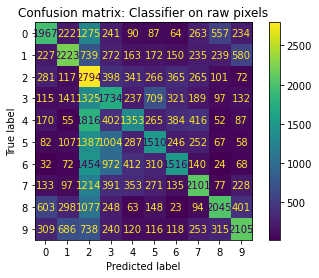

In [196]:
plot_confusion_matrix(clf, np.reshape(xval,(-1,3*32*32)),yval.T[0])
plt.title('Confusion matrix: Classifier on raw pixels')
plt.savefig('./paper_data/cifar10/confusion_matrix_raw_pixels.png',dpi=300)

### 5.3 Discussion of Results: Comparison to the paper and Insights gained

From the figures presented above it is evident that when the paper was closely followed the results are significantly better than those that were obtained when it wasn't. This is probably due to the fact that in the low data regime the generator is not able to learn features that are as meaningful as those in a high data regime. Additionally, it is also probable that reducing the capacity of the network as was neccesary in this case further aggravates the situation. 

In the case of the Celeba dataset then it is clear that all of the experiments were succesful in the sense that the results from my model matched closely those of the paper. However, in the case of the cifar 10 experiment I believe that the results are only partially sucessful as they show that it is possible to learn a better feature representation using the DCGAN model, but this representaion is not superior to the traditional methods explained in the paper. 

### 5.3.1 Insights from Celeba experiments
Although we were able to show that it is possible to reproduce the results in paper an important insight that was not originally in the latter is that representations get tangled as more information gets added. In other words, when we performed the interpolation exercises it is clear the transition included not only features such as facial shape and hair color, but also background, lighting and texture. This makes it harder to perform algebraic manipulations because each picture doesn't have such a clear cut interpretation. It is likely that the paper omitted algebraic manipulations with the other datasets precisely because of this issue. 

### 5.3.2 Insights from Cifar experiments
The cifar experiment didn't perform nearly as well as in the paper but this is probably because the training conditions were very different. In the paper, a larger network and more images were used. In my project, given that I decided to train on a smaller number of images, I had to reduce the number capacity of the discriminator to avoid serious instability. An SVM trained in this way yieled an accuracy of $0.49$ while the paper managed to achieve an accuracy of of $0.82$. This shows that large quantities of data are required. 

Additionally, although the results were unsucessful in terms of the learned features they were succesful in terms of generated images. However, various changes needed to be made to the model. In particular, it was neccesary to add dropout, reduce the capacity of the discriminator, add smooth labels, and alter the traing strategy to compute the gradients in two steps. This shows that GAN training is still unstable even if a DCGAN is used. As a possible future direcition, I believe it would be interesting to attempt the same experiments with auxiliary labels and feature matching (Salimans et al 2016). In the paper where these techinques are proposed they managed to obtain better image generation. Attempting this experiment would be good because we would able to confirm that the low quality of the features is related to the quality of the image produced. 

### 6 Conclusions
DCGANS provide a useful and important alterantive to traditional GANs by producing higher quality images. The manifold learned provides useful and meaningful representations that can be used to understand the generation process. Additionally, the discriminator can be used as a method for feature extraction in unsupervised settings. However, the quality of the representations becomes entangled the more information we add to the image and the quality of the features extracted diminishes as the amount of data is reduced. Although DCGANS are in many ways an improvement over traidional GANs, in various situations it is still very important to use "tricks" that further help with stability during training. 

